## Prepare datasets

In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
DATA_PATH = "/content/drive/MyDrive/Image_Segmentation/CityScapes Dataset"

## Import some Library

In [5]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import matplotlib.pyplot as plt

## Datasets Loader

In [6]:
class CityScapes(torch.utils.data.Dataset):
  def __init__(self, image_folder_path, mask_folder_path, transform=None):
    self.image_folder_path = image_folder_path
    self.mask_folder_path = mask_folder_path
    self.transform = transform
    self.images = os.listdir(image_folder_path)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_folder_path, self.images[index])
    mask_path = os.path.join(self.mask_folder_path, self.images[index])
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask

In [7]:
os.listdir(DATA_PATH)

['annotations_prepped_train',
 'images_prepped_train',
 'annotations_prepped_test',
 'images_prepped_test']

In [8]:
TRAIN_IMG_DIR = os.path.join(DATA_PATH, 'images_prepped_train')
TRAIN_MASK_DIR = os.path.join(DATA_PATH, 'annotations_prepped_train')

TEST_IMG_DIR = os.path.join(DATA_PATH, 'images_prepped_test')
TEST_MASK_DIR = os.path.join(DATA_PATH, 'annotations_prepped_test')

In [9]:
data_transforms = A.Compose([
    A.Resize(256,256),
    A.Normalize(),
    ToTensorV2()
])

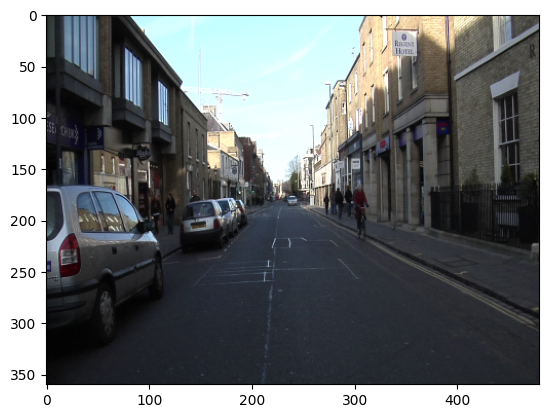

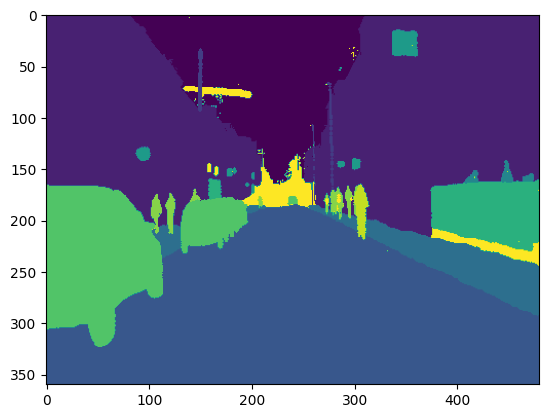

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
(360, 480, 3)


In [10]:
sample = CityScapes(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
image, mask = sample[0]
plt.imshow(image)
plt.show()
plt.imshow(mask)
plt.show()

print(np.unique(mask))
print(image.shape)

In [11]:
train_dataset = CityScapes(TRAIN_IMG_DIR, TRAIN_MASK_DIR, data_transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

test_dataset = CityScapes(TEST_IMG_DIR, TEST_MASK_DIR, data_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

## Model Architecture

## DoubleConv

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

## UNet

In [13]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # doblemconv, dobleconv..
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        #upsam, doubleconv, up, ..
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(#0
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))#1

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reversed(skip_connections)

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# FCN8s

In [ ]:
class FCN8s(nn.Module):
  def __init__(self, in_channels, out_channels, features= [64, 128, 256, 512, 1024]):
    super().__init__()
    self.layers = nn.ModuleList()
    self.pool = nn.MaxPool2d(2, 2)

    for feature in features:
      self.layers.append(DoubleConv(in_channels, feature))
      in_channels = feature

    self.ups1 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
    self.ups2 = nn.ConvTranspose2d(features[-1], features[-3], kernel_size=2, stride=2)

    self.predictions = nn.ConvTranspose2d(features[-2], out_channels, kernel_size=8, stride=8)

  def forward(self, x):
    skip_connections=[]

    for idx,layer in enumerate(self.layers):
      x = layer(x)
      x = self.pool(x)
      if idx in [2,3]:
        skip_connections.append(x)


    ups1 = self.ups1(x)
    concat1 = torch.concat([ups1, skip_connections[-1]], dim=1)

    ups2 = self.ups2(concat1)
    concat2 = torch.concat([ups2, skip_connections[-2]], dim=1)

    return self.predictions(concat2)

## Engine function

## Dice coefficient metrics

In [14]:
def calculate_dice_coefficient(ground_truth, predicted):
    intersection = np.logical_and(ground_truth, predicted)
    dice_coefficient = (2 * np.sum(intersection)) / (np.sum(ground_truth) + np.sum(predicted))
    return dice_coefficient

def calculate_dice_coefficients(ground_truths, predictions):
    num_samples = len(ground_truths)
    dice_coefficients = np.zeros(num_samples)
    for i in range(num_samples):
      dice_coefficients[i] = calculate_dice_coefficient(ground_truths[i], predictions[i])
    return dice_coefficients

## IoU Metrics

In [15]:
def calculate_iou_score(ground_truth, predicted):
    intersection = np.logical_and(ground_truth, predicted)
    union = np.logical_or(ground_truth, predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_iou_scores(ground_truths, predictions):
    num_samples = len(ground_truths)
    iou_scores = np.zeros(num_samples)
    for i in range(num_samples):
        iou_scores[i] = calculate_iou_score(ground_truths[i], predictions[i])
    return iou_scores

## Training Phase

In [17]:
!pip install torchmetrics

In [18]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchmetrics

In [19]:
def check_dice_score(loader, model, device):
    dice_score = 0
    dice_score_function = torchmetrics.Dice(num_classes=12, average='micro').to(device)
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = torch.as_tensor(y, dtype=torch.int64, device=device)
            preds = model(x)
            dice_score += dice_score_function(preds, y)

    print(f"Dice score: {dice_score/len(loader)}")
    print(f"Loss Dice score: {1 - dice_score/len(loader)}")
    model.train()

In [20]:
def train_epoch(model, dataloader, criterion, optimizer, scaler, device):
  #please do training step in this function
  model.train()
  loss_one_step = 0
  loop = tqdm(dataloader)
  for data, targets in loop:
      data = data.to('cuda')
      targets = torch.as_tensor(targets, dtype=torch.int64, device=device)
      # forward
      with torch.cuda.amp.autocast():
          predictions = model(data)
          loss = criterion(predictions, targets)

      optimizer.zero_grad()
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      loss_one_step += loss.item()

      # update tqdm loop
      loop.set_postfix(loss=loss.item())

  return loss_one_step / len(dataloader)

def evaluate(model, dataloader, criterion, device):
  #please do evaluation step that calculate evaluation loss and evaluation metrics dice_score_coefficient
  model.eval()
  dice_score = 0
  dice_score_function = torchmetrics.Dice(num_classes=12, average='micro').to(device)

  loss_one_step = 0
  loop = tqdm(dataloader)

  for data, targets in loop:
      data = data.to('cuda')
      targets = torch.as_tensor(targets, dtype=torch.int64, device=device)
      with torch.no_grad():
          with torch.cuda.amp.autocast():
              predictions = model(data)
              loss = criterion(predictions, targets)

              # Dice Score
              dice_score += dice_score_function(predictions, targets)

      loss_one_step += loss.item()

      loop.set_postfix(loss=loss.item())

  return loss_one_step / len(dataloader), dice_score / len(dataloader)

In [21]:
def train(model, num_epochs=5):
  #please init everthing in here and do the training process
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
  scaler = torch.cuda.amp.GradScaler()
  for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch+1} of {num_epochs}")
    train_loss = train_epoch(model, train_dataloader, criterion, optimizer, scaler, device)
    test_loss, dice_score = evaluate(model, test_dataloader, criterion, device)
    print("\nDice Score : ", dice_score.cpu().numpy())
    print("Loss Dice Score : ", 1 - dice_score.cpu().numpy())
    print()

In [22]:
model = UNET(3, 12)
train(model, num_epochs=100)

[INFO]: Epoch 1 of 100


100%|██████████| 7/7 [00:47<00:00,  6.72s/it, loss=3.66]



Dice Score :  0.5280637
Loss Dice Score :  0.47193628549575806

[INFO]: Epoch 2 of 100


100%|██████████| 7/7 [00:01<00:00,  3.78it/s, loss=1.25]



Dice Score :  0.61823404
Loss Dice Score :  0.3817659616470337

[INFO]: Epoch 3 of 100


100%|██████████| 7/7 [00:02<00:00,  2.70it/s, loss=1.23]



Dice Score :  0.6259651
Loss Dice Score :  0.3740348815917969

[INFO]: Epoch 4 of 100


100%|██████████| 7/7 [00:01<00:00,  3.63it/s, loss=0.76]



Dice Score :  0.7950875
Loss Dice Score :  0.2049124836921692

[INFO]: Epoch 5 of 100


100%|██████████| 7/7 [00:01<00:00,  4.11it/s, loss=0.928]



Dice Score :  0.6945049
Loss Dice Score :  0.30549508333206177

[INFO]: Epoch 6 of 100


100%|██████████| 7/7 [00:01<00:00,  4.12it/s, loss=0.784]



Dice Score :  0.76260155
Loss Dice Score :  0.2373984456062317

[INFO]: Epoch 7 of 100


100%|██████████| 7/7 [00:01<00:00,  4.19it/s, loss=0.734]



Dice Score :  0.8033555
Loss Dice Score :  0.19664448499679565

[INFO]: Epoch 8 of 100


100%|██████████| 7/7 [00:01<00:00,  3.87it/s, loss=0.624]



Dice Score :  0.8243697
Loss Dice Score :  0.17563027143478394

[INFO]: Epoch 9 of 100


100%|██████████| 7/7 [00:02<00:00,  2.79it/s, loss=0.841]



Dice Score :  0.7497982
Loss Dice Score :  0.2502018213272095

[INFO]: Epoch 10 of 100


100%|██████████| 7/7 [00:02<00:00,  2.80it/s, loss=0.512]



Dice Score :  0.8586117
Loss Dice Score :  0.14138829708099365

[INFO]: Epoch 11 of 100


100%|██████████| 7/7 [00:01<00:00,  3.92it/s, loss=0.556]



Dice Score :  0.8473021
Loss Dice Score :  0.15269792079925537

[INFO]: Epoch 12 of 100


100%|██████████| 7/7 [00:01<00:00,  4.22it/s, loss=0.472]



Dice Score :  0.8662108
Loss Dice Score :  0.13378918170928955

[INFO]: Epoch 13 of 100


100%|██████████| 7/7 [00:01<00:00,  4.10it/s, loss=0.484]



Dice Score :  0.8667212
Loss Dice Score :  0.13327878713607788

[INFO]: Epoch 14 of 100


100%|██████████| 7/7 [00:01<00:00,  4.12it/s, loss=0.521]



Dice Score :  0.8340569
Loss Dice Score :  0.16594308614730835

[INFO]: Epoch 15 of 100


100%|██████████| 7/7 [00:01<00:00,  3.79it/s, loss=0.451]



Dice Score :  0.8674408
Loss Dice Score :  0.1325591802597046

[INFO]: Epoch 16 of 100


100%|██████████| 7/7 [00:02<00:00,  2.76it/s, loss=0.58]



Dice Score :  0.8010587
Loss Dice Score :  0.19894129037857056

[INFO]: Epoch 17 of 100


100%|██████████| 7/7 [00:02<00:00,  2.65it/s, loss=0.426]



Dice Score :  0.86470526
Loss Dice Score :  0.13529473543167114

[INFO]: Epoch 18 of 100


100%|██████████| 7/7 [00:02<00:00,  3.25it/s, loss=0.442]



Dice Score :  0.8611911
Loss Dice Score :  0.13880890607833862

[INFO]: Epoch 19 of 100


100%|██████████| 7/7 [00:01<00:00,  3.93it/s, loss=0.445]



Dice Score :  0.8602619
Loss Dice Score :  0.1397380828857422

[INFO]: Epoch 20 of 100


100%|██████████| 7/7 [00:01<00:00,  4.06it/s, loss=0.507]



Dice Score :  0.8312077
Loss Dice Score :  0.16879230737686157

[INFO]: Epoch 21 of 100


100%|██████████| 7/7 [00:01<00:00,  4.15it/s, loss=0.43]



Dice Score :  0.86101013
Loss Dice Score :  0.1389898657798767

[INFO]: Epoch 22 of 100


100%|██████████| 7/7 [00:01<00:00,  3.91it/s, loss=0.424]



Dice Score :  0.86052155
Loss Dice Score :  0.13947844505310059

[INFO]: Epoch 23 of 100


100%|██████████| 7/7 [00:01<00:00,  3.61it/s, loss=0.351]



Dice Score :  0.8781534
Loss Dice Score :  0.12184661626815796

[INFO]: Epoch 24 of 100


100%|██████████| 7/7 [00:02<00:00,  2.61it/s, loss=0.5]



Dice Score :  0.84149975
Loss Dice Score :  0.15850025415420532

[INFO]: Epoch 25 of 100


100%|██████████| 7/7 [00:02<00:00,  2.61it/s, loss=0.457]



Dice Score :  0.8585916
Loss Dice Score :  0.14140838384628296

[INFO]: Epoch 26 of 100


100%|██████████| 7/7 [00:01<00:00,  3.65it/s, loss=0.428]



Dice Score :  0.86713225
Loss Dice Score :  0.1328677535057068

[INFO]: Epoch 27 of 100


100%|██████████| 7/7 [00:01<00:00,  3.98it/s, loss=0.41]



Dice Score :  0.85906386
Loss Dice Score :  0.14093613624572754

[INFO]: Epoch 28 of 100


100%|██████████| 7/7 [00:01<00:00,  3.95it/s, loss=0.34]



Dice Score :  0.88411456
Loss Dice Score :  0.11588543653488159

[INFO]: Epoch 29 of 100


100%|██████████| 7/7 [00:01<00:00,  3.95it/s, loss=0.354]



Dice Score :  0.89172685
Loss Dice Score :  0.10827314853668213

[INFO]: Epoch 30 of 100


100%|██████████| 7/7 [00:01<00:00,  4.07it/s, loss=0.42]



Dice Score :  0.86874586
Loss Dice Score :  0.1312541365623474

[INFO]: Epoch 31 of 100


100%|██████████| 7/7 [00:01<00:00,  3.51it/s, loss=0.445]



Dice Score :  0.85920894
Loss Dice Score :  0.14079105854034424

[INFO]: Epoch 32 of 100


100%|██████████| 7/7 [00:02<00:00,  2.68it/s, loss=0.382]



Dice Score :  0.87691134
Loss Dice Score :  0.12308865785598755

[INFO]: Epoch 33 of 100


100%|██████████| 7/7 [00:02<00:00,  2.66it/s, loss=0.386]



Dice Score :  0.87499726
Loss Dice Score :  0.12500274181365967

[INFO]: Epoch 34 of 100


100%|██████████| 7/7 [00:02<00:00,  2.84it/s, loss=0.353]



Dice Score :  0.89128006
Loss Dice Score :  0.10871994495391846

[INFO]: Epoch 35 of 100


100%|██████████| 7/7 [00:01<00:00,  4.08it/s, loss=0.683]



Dice Score :  0.8031581
Loss Dice Score :  0.19684189558029175

[INFO]: Epoch 36 of 100


100%|██████████| 7/7 [00:01<00:00,  4.07it/s, loss=0.346]



Dice Score :  0.90029305
Loss Dice Score :  0.09970694780349731

[INFO]: Epoch 37 of 100


100%|██████████| 7/7 [00:01<00:00,  4.08it/s, loss=0.369]



Dice Score :  0.8888689
Loss Dice Score :  0.11113107204437256

[INFO]: Epoch 38 of 100


100%|██████████| 7/7 [00:01<00:00,  4.12it/s, loss=0.358]



Dice Score :  0.89194095
Loss Dice Score :  0.10805904865264893

[INFO]: Epoch 39 of 100


100%|██████████| 7/7 [00:02<00:00,  2.54it/s, loss=0.35]



Dice Score :  0.8890736
Loss Dice Score :  0.11092638969421387

[INFO]: Epoch 40 of 100


100%|██████████| 7/7 [00:02<00:00,  2.56it/s, loss=0.359]



Dice Score :  0.89160115
Loss Dice Score :  0.10839885473251343

[INFO]: Epoch 41 of 100


100%|██████████| 7/7 [00:02<00:00,  2.94it/s, loss=0.31]



Dice Score :  0.9054053
Loss Dice Score :  0.09459471702575684

[INFO]: Epoch 42 of 100


100%|██████████| 7/7 [00:01<00:00,  3.78it/s, loss=0.345]



Dice Score :  0.8913241
Loss Dice Score :  0.10867589712142944

[INFO]: Epoch 43 of 100


100%|██████████| 7/7 [00:01<00:00,  4.09it/s, loss=0.309]



Dice Score :  0.8999646
Loss Dice Score :  0.10003542900085449

[INFO]: Epoch 44 of 100


100%|██████████| 7/7 [00:01<00:00,  3.98it/s, loss=0.327]



Dice Score :  0.9032429
Loss Dice Score :  0.09675711393356323

[INFO]: Epoch 45 of 100


100%|██████████| 7/7 [00:01<00:00,  4.13it/s, loss=0.32]



Dice Score :  0.9050958
Loss Dice Score :  0.09490418434143066

[INFO]: Epoch 46 of 100


100%|██████████| 7/7 [00:01<00:00,  4.09it/s, loss=0.416]



Dice Score :  0.87460566
Loss Dice Score :  0.12539434432983398

[INFO]: Epoch 47 of 100


100%|██████████| 7/7 [00:02<00:00,  3.24it/s, loss=0.333]



Dice Score :  0.9022187
Loss Dice Score :  0.09778130054473877

[INFO]: Epoch 48 of 100


100%|██████████| 7/7 [00:02<00:00,  2.77it/s, loss=0.324]



Dice Score :  0.903083
Loss Dice Score :  0.09691697359085083

[INFO]: Epoch 49 of 100


100%|██████████| 7/7 [00:02<00:00,  2.84it/s, loss=0.433]



Dice Score :  0.8742101
Loss Dice Score :  0.12578988075256348

[INFO]: Epoch 50 of 100


100%|██████████| 7/7 [00:01<00:00,  4.02it/s, loss=0.327]



Dice Score :  0.89504164
Loss Dice Score :  0.10495835542678833

[INFO]: Epoch 51 of 100


100%|██████████| 7/7 [00:01<00:00,  4.04it/s, loss=0.308]



Dice Score :  0.9003809
Loss Dice Score :  0.09961909055709839

[INFO]: Epoch 52 of 100


100%|██████████| 7/7 [00:02<00:00,  2.67it/s, loss=0.302]



Dice Score :  0.9019482
Loss Dice Score :  0.09805178642272949

[INFO]: Epoch 53 of 100


100%|██████████| 7/7 [00:01<00:00,  4.05it/s, loss=0.309]



Dice Score :  0.90382594
Loss Dice Score :  0.09617406129837036

[INFO]: Epoch 54 of 100


100%|██████████| 7/7 [00:01<00:00,  3.93it/s, loss=0.291]



Dice Score :  0.9080036
Loss Dice Score :  0.09199637174606323

[INFO]: Epoch 55 of 100


100%|██████████| 7/7 [00:01<00:00,  3.88it/s, loss=0.315]



Dice Score :  0.9074819
Loss Dice Score :  0.09251809120178223

[INFO]: Epoch 56 of 100


100%|██████████| 7/7 [00:02<00:00,  2.87it/s, loss=0.372]



Dice Score :  0.8914504
Loss Dice Score :  0.10854959487915039

[INFO]: Epoch 57 of 100


100%|██████████| 7/7 [00:02<00:00,  2.54it/s, loss=0.314]



Dice Score :  0.90663165
Loss Dice Score :  0.09336835145950317

[INFO]: Epoch 58 of 100


100%|██████████| 7/7 [00:02<00:00,  2.88it/s, loss=0.322]



Dice Score :  0.89832336
Loss Dice Score :  0.10167664289474487

[INFO]: Epoch 59 of 100


100%|██████████| 7/7 [00:01<00:00,  4.01it/s, loss=0.316]



Dice Score :  0.8991059
Loss Dice Score :  0.10089409351348877

[INFO]: Epoch 60 of 100


100%|██████████| 7/7 [00:01<00:00,  3.97it/s, loss=0.303]



Dice Score :  0.9081381
Loss Dice Score :  0.09186190366744995

[INFO]: Epoch 61 of 100


100%|██████████| 7/7 [00:01<00:00,  3.98it/s, loss=0.33]



Dice Score :  0.90318453
Loss Dice Score :  0.09681546688079834

[INFO]: Epoch 62 of 100


100%|██████████| 7/7 [00:01<00:00,  4.03it/s, loss=0.328]



Dice Score :  0.9139012
Loss Dice Score :  0.08609879016876221

[INFO]: Epoch 63 of 100


100%|██████████| 7/7 [00:01<00:00,  4.02it/s, loss=0.306]



Dice Score :  0.90688866
Loss Dice Score :  0.09311133623123169

[INFO]: Epoch 64 of 100


100%|██████████| 7/7 [00:02<00:00,  2.91it/s, loss=0.308]



Dice Score :  0.90502185
Loss Dice Score :  0.09497815370559692

[INFO]: Epoch 65 of 100


100%|██████████| 7/7 [00:02<00:00,  2.65it/s, loss=0.313]



Dice Score :  0.91020536
Loss Dice Score :  0.08979463577270508

[INFO]: Epoch 66 of 100


100%|██████████| 7/7 [00:02<00:00,  2.65it/s, loss=0.304]



Dice Score :  0.91417855
Loss Dice Score :  0.08582144975662231

[INFO]: Epoch 67 of 100


100%|██████████| 7/7 [00:02<00:00,  2.89it/s, loss=0.351]



Dice Score :  0.9024444
Loss Dice Score :  0.09755557775497437

[INFO]: Epoch 68 of 100


100%|██████████| 7/7 [00:01<00:00,  4.04it/s, loss=0.317]



Dice Score :  0.9073307
Loss Dice Score :  0.09266930818557739

[INFO]: Epoch 69 of 100


100%|██████████| 7/7 [00:01<00:00,  4.11it/s, loss=0.284]



Dice Score :  0.91438246
Loss Dice Score :  0.0856175422668457

[INFO]: Epoch 70 of 100


100%|██████████| 7/7 [00:01<00:00,  3.98it/s, loss=0.296]



Dice Score :  0.91190356
Loss Dice Score :  0.08809643983840942

[INFO]: Epoch 71 of 100


100%|██████████| 7/7 [00:01<00:00,  4.03it/s, loss=0.329]



Dice Score :  0.908654
Loss Dice Score :  0.09134602546691895

[INFO]: Epoch 72 of 100


100%|██████████| 7/7 [00:01<00:00,  4.00it/s, loss=0.292]



Dice Score :  0.912253
Loss Dice Score :  0.08774697780609131

[INFO]: Epoch 73 of 100


100%|██████████| 7/7 [00:02<00:00,  3.48it/s, loss=0.356]



Dice Score :  0.89785635
Loss Dice Score :  0.10214364528656006

[INFO]: Epoch 74 of 100


100%|██████████| 7/7 [00:02<00:00,  2.82it/s, loss=0.318]



Dice Score :  0.9095199
Loss Dice Score :  0.09048008918762207

[INFO]: Epoch 75 of 100


100%|██████████| 7/7 [00:02<00:00,  2.57it/s, loss=0.321]



Dice Score :  0.9079938
Loss Dice Score :  0.09200620651245117

[INFO]: Epoch 76 of 100


100%|██████████| 7/7 [00:02<00:00,  2.86it/s, loss=0.296]



Dice Score :  0.91315585
Loss Dice Score :  0.08684414625167847

[INFO]: Epoch 77 of 100


100%|██████████| 7/7 [00:01<00:00,  3.90it/s, loss=0.318]



Dice Score :  0.90849835
Loss Dice Score :  0.09150165319442749

[INFO]: Epoch 78 of 100


100%|██████████| 7/7 [00:01<00:00,  3.93it/s, loss=0.353]



Dice Score :  0.89177436
Loss Dice Score :  0.10822564363479614

[INFO]: Epoch 79 of 100


100%|██████████| 7/7 [00:01<00:00,  4.03it/s, loss=0.308]



Dice Score :  0.9117468
Loss Dice Score :  0.0882532000541687

[INFO]: Epoch 80 of 100


100%|██████████| 7/7 [00:01<00:00,  3.96it/s, loss=0.317]



Dice Score :  0.91128147
Loss Dice Score :  0.08871853351593018

[INFO]: Epoch 81 of 100


100%|██████████| 7/7 [00:02<00:00,  3.34it/s, loss=0.301]



Dice Score :  0.91377574
Loss Dice Score :  0.0862242579460144

[INFO]: Epoch 82 of 100


100%|██████████| 7/7 [00:02<00:00,  2.63it/s, loss=0.348]



Dice Score :  0.9085699
Loss Dice Score :  0.09143012762069702

[INFO]: Epoch 83 of 100


100%|██████████| 7/7 [00:02<00:00,  2.62it/s, loss=0.295]



Dice Score :  0.91493565
Loss Dice Score :  0.0850643515586853

[INFO]: Epoch 84 of 100


100%|██████████| 7/7 [00:02<00:00,  3.16it/s, loss=0.282]



Dice Score :  0.9170041
Loss Dice Score :  0.08299589157104492

[INFO]: Epoch 85 of 100


100%|██████████| 7/7 [00:01<00:00,  4.04it/s, loss=0.329]



Dice Score :  0.903527
Loss Dice Score :  0.09647297859191895

[INFO]: Epoch 86 of 100


100%|██████████| 7/7 [00:01<00:00,  4.01it/s, loss=0.316]



Dice Score :  0.9137512
Loss Dice Score :  0.08624881505966187

[INFO]: Epoch 87 of 100


100%|██████████| 7/7 [00:01<00:00,  4.06it/s, loss=0.331]



Dice Score :  0.91154075
Loss Dice Score :  0.08845925331115723

[INFO]: Epoch 88 of 100


100%|██████████| 7/7 [00:01<00:00,  4.09it/s, loss=0.305]



Dice Score :  0.91638
Loss Dice Score :  0.08362001180648804

[INFO]: Epoch 89 of 100


100%|██████████| 7/7 [00:01<00:00,  4.10it/s, loss=0.317]



Dice Score :  0.9112256
Loss Dice Score :  0.08877438306808472

[INFO]: Epoch 90 of 100


100%|██████████| 7/7 [00:02<00:00,  2.96it/s, loss=0.311]



Dice Score :  0.9140952
Loss Dice Score :  0.08590477705001831

[INFO]: Epoch 91 of 100


100%|██████████| 7/7 [00:02<00:00,  2.66it/s, loss=0.32]



Dice Score :  0.9149709
Loss Dice Score :  0.08502912521362305

[INFO]: Epoch 92 of 100


100%|██████████| 7/7 [00:02<00:00,  2.42it/s, loss=0.327]



Dice Score :  0.9134033
Loss Dice Score :  0.08659672737121582

[INFO]: Epoch 93 of 100


100%|██████████| 7/7 [00:01<00:00,  4.17it/s, loss=0.308]



Dice Score :  0.91262674
Loss Dice Score :  0.08737325668334961

[INFO]: Epoch 94 of 100


100%|██████████| 7/7 [00:01<00:00,  4.11it/s, loss=0.324]



Dice Score :  0.90934455
Loss Dice Score :  0.09065544605255127

[INFO]: Epoch 95 of 100


100%|██████████| 7/7 [00:01<00:00,  3.96it/s, loss=0.312]



Dice Score :  0.91487044
Loss Dice Score :  0.08512955904006958

[INFO]: Epoch 96 of 100


100%|██████████| 7/7 [00:01<00:00,  4.27it/s, loss=0.345]



Dice Score :  0.9129687
Loss Dice Score :  0.0870313048362732

[INFO]: Epoch 97 of 100


100%|██████████| 7/7 [00:01<00:00,  3.94it/s, loss=0.322]



Dice Score :  0.91316986
Loss Dice Score :  0.08683013916015625

[INFO]: Epoch 98 of 100


100%|██████████| 7/7 [00:02<00:00,  2.91it/s, loss=0.299]



Dice Score :  0.91490614
Loss Dice Score :  0.08509385585784912

[INFO]: Epoch 99 of 100


100%|██████████| 7/7 [00:02<00:00,  2.72it/s, loss=0.377]



Dice Score :  0.9031075
Loss Dice Score :  0.09689247608184814

[INFO]: Epoch 100 of 100


100%|██████████| 7/7 [00:02<00:00,  2.91it/s, loss=0.312]


Dice Score :  0.9116745
Loss Dice Score :  0.08832550048828125



In [23]:
# cuma test2 saja, hasilnya sama dgn epoch terakhir di training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
check_dice_score(test_dataloader, model, device)

Dice score: 0.9116951823234558
Loss Dice score: 0.08830481767654419


# Test Inference

In [24]:
def inference(tensor):
  model.eval()
  with torch.no_grad():
    tensor = torch.unsqueeze(tensor, dim=0).to('cuda')
    result = model(tensor)
    softmax = nn.Softmax(dim=1)
    result = torch.argmax(softmax(result),axis=1).to('cpu')

  return result

def img_to_numpy(tensor):
  tensor = torch.squeeze(tensor)
  tensor = tensor.cpu().detach().numpy()
  return tensor

def inverse_transform(img):
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = img_to_numpy(img).transpose((1,2,0))
  img = (img * std+mean)
  img = np.clip(img,0,1)
  return img

def plot_inference(idx, dataset):
  fig = plt.figure(figsize=(18, 18))
  img, targets = dataset[idx]
  result = inference(img)

  fig.add_subplot(1, 3, 1)
  inv_img = inverse_transform(img)
  plt.imshow(inv_img)
  plt.axis('off')
  plt.title("Image")

  fig.add_subplot(1, 3, 2)
  plt.imshow(img_to_numpy(targets))
  plt.axis('off')
  plt.title("Target")

  fig.add_subplot(1, 3, 3)
  plt.imshow(img_to_numpy(result))
  plt.axis('off')
  plt.title("Prediction")

  plt.show()

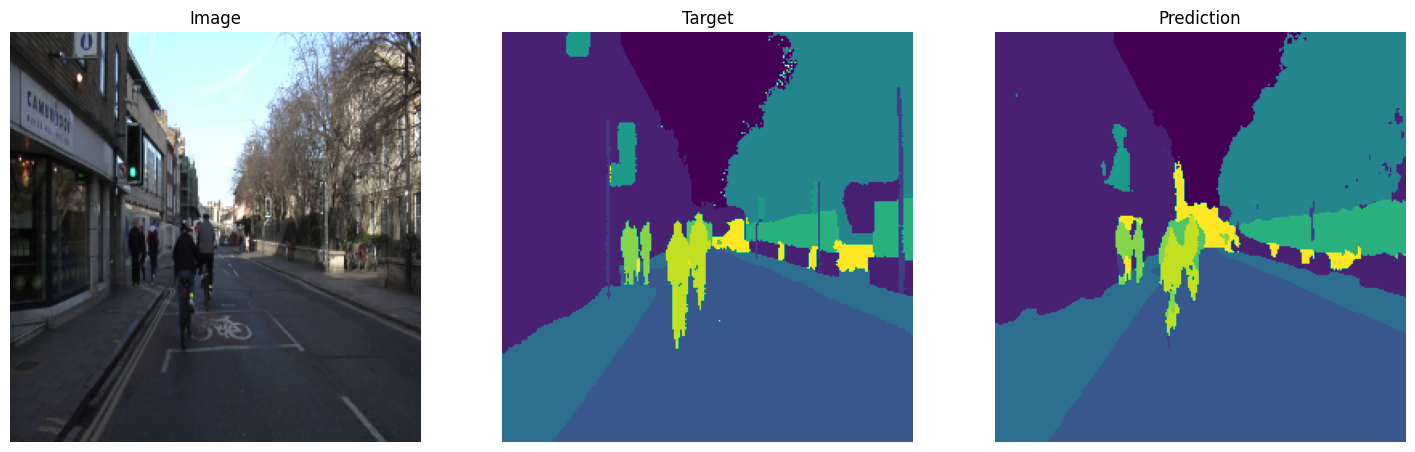

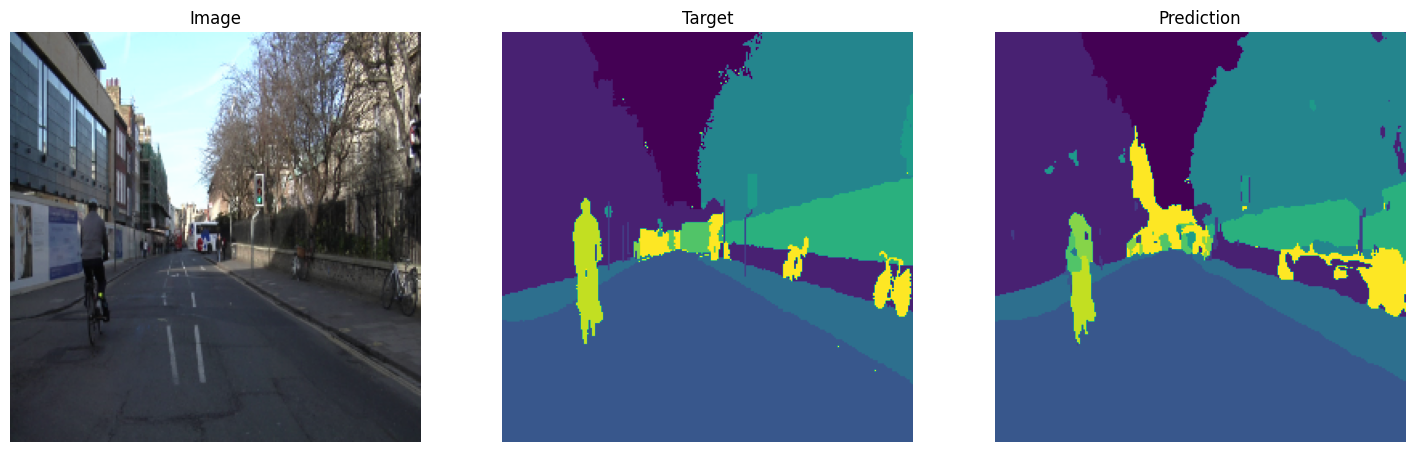

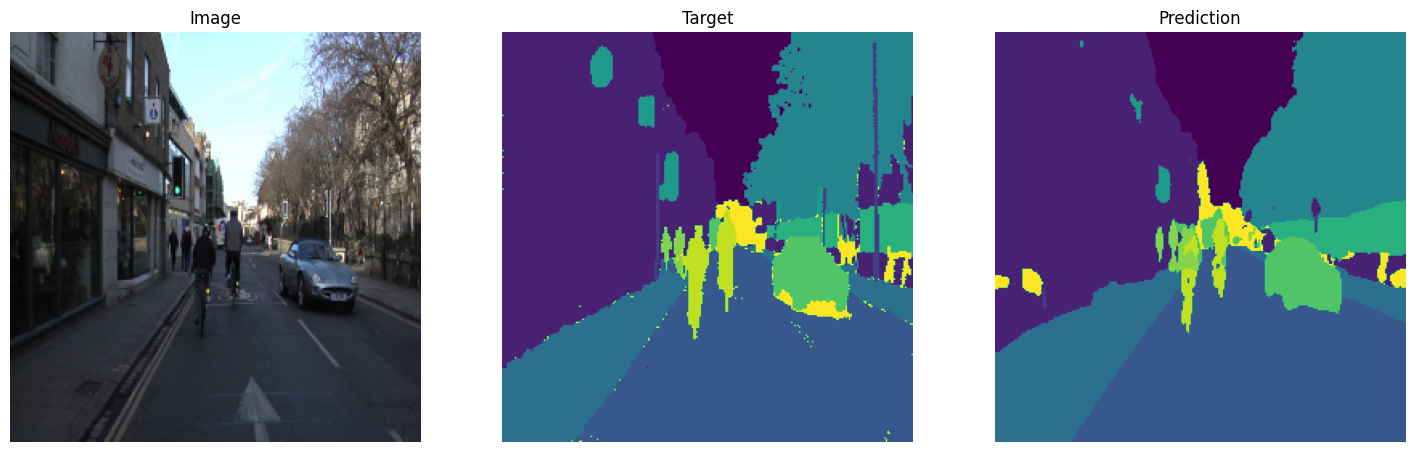

In [25]:
get_img = 3 #inference 3 img

for idx in range(get_img):
  plot_inference(idx, test_dataset)